# Predict Zero-inflated and Long-tailed Outcomes

## Load Dataset

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import boto3
import json
from tqdm.auto import tqdm
import time

def string_to_yearmon(date):
    date = date.split()
    date = date[0].split('/') + date[1].split(':')
    date = date[2] + '-' + date[0].zfill(2) #+ '-' + date[1].zfill(2) + ' ' + date[3].zfill(2) + ':' + date[4].zfill(2)
    return date

def call_llama(system_prompt, input):
    template = f"""<s>[INST] <<SYS>>{system_prompt}<</SYS>>{input}[/INST]"""
    client = boto3.client(service_name='bedrock-runtime',region_name='us-west-2')
    body = json.dumps({
        "prompt": template,
        "temperature": 0.,
        "top_p": 0.9,
        "max_gen_len": 2048,
    })
    response = client.invoke_model(
        body=body,
        modelId='us.meta.llama3-2-90b-instruct-v1:0',
        accept='application/json',
        contentType='application/json'
    )
    response_body = json.loads(response['body'].read())
    return response_body

def call_claude(system_prompt, input):
    client = boto3.client(service_name='bedrock-runtime',region_name='us-west-2')
    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 2048,
            "messages": [
                {
                    "role": "user",
                    "content": [
                    {
                        "type": "text",
                        "text": system_prompt + '\n' + input,
                    }
                    ]
                }
                ]
        }  
    )  

    
    response = client.invoke_model(body=body, 
                                   modelId='anthropic.claude-3-5-sonnet-20241022-v2:0',
                                   contentType='application/json',
                                   accept='application/json')
    response_body = json.loads(response.get('body').read())
   
    return response_body

## Clean Dataset

In [2]:
online_retail = fetch_ucirepo(id=352) 
transaction_df = online_retail['data']['original']
transaction_df.shape

(541909, 8)

In [3]:
#create yearmon for train-valid split
transaction_df['yearmon'] = transaction_df.InvoiceDate.map(string_to_yearmon)

#get rid of transactions without cid
transaction_df = transaction_df[~transaction_df.CustomerID.isna()].reset_index(drop=True)

#fill in unknown descriptions
transaction_df.Description = transaction_df.Description.fillna('UNKNOWN')

#convert customer id to string
transaction_df['CustomerID'] = transaction_df['CustomerID'].map(lambda x: str(int(x)))

transaction_df.shape

(406829, 9)

In [4]:
#check if still na
transaction_df.isna().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
yearmon        0.0
dtype: float64

In [5]:
#simplify by filtering unit price and quantity to be non-zero (get rid of discounts, cancellations, etc)
transaction_df = transaction_df[(transaction_df.UnitPrice>0)&\
                                (transaction_df.Quantity>0)].reset_index(drop=True)
#add sales
transaction_df['Sales'] = transaction_df.UnitPrice * transaction_df.Quantity
transaction_df.shape

(397884, 10)

## Outcome

In [6]:
feature_period = {'start': '2011-01', 'end': '2011-09'}
outcome_period = {'start': '2011-10', 'end': '2011-12'}

feature_transaction = transaction_df[(transaction_df.yearmon>=feature_period['start'])&\
                                      (transaction_df.yearmon<=feature_period['end'])]
outcome_transaction = transaction_df[(transaction_df.yearmon>=outcome_period['start'])&\
                                      (transaction_df.yearmon<=outcome_period['end'])]
feature_transaction.shape, outcome_transaction.shape

((240338, 10), (131389, 10))

In [7]:
#aggregate sales during outcome period
outcome_sales = outcome_transaction.groupby('CustomerID').Sales.sum().reset_index()
outcome_sales

,CustomerID,Sales
0,12347,1519.14
1,12349,1757.55
2,12352,311.73
3,12356,58.35
4,12357,6207.67
...,...,...
2555,18276,335.86
2556,18277,110.38
2557,18282,77.84
2558,18283,974.21


In [8]:
#aggregate sales during feature period
feature_sales = feature_transaction.groupby('CustomerID').Sales.sum().reset_index()
feature_sales

,CustomerID,Sales
0,12346,77183.60
1,12347,2079.07
2,12348,904.44
3,12350,334.40
4,12352,2194.31
...,...,...
3433,18280,180.60
3434,18281,80.82
3435,18282,100.21
3436,18283,1120.67


In [9]:
#merge to get TargetSales including those who spent during feature period but not during outcome (zeroes)
outcome_df = feature_sales[['CustomerID']].merge(outcome_sales, on='CustomerID', how='left')
outcome_df['Sales'] = outcome_df['Sales'].fillna(0)
outcome_df.columns = ['CustomerID', 'TargetSales']
outcome_df

,CustomerID,TargetSales
0,12346,0.00
1,12347,1519.14
2,12348,0.00
3,12350,0.00
4,12352,311.73
...,...,...
3433,18280,0.00
3434,18281,0.00
3435,18282,77.84
3436,18283,974.21


In [10]:
#confirm zero-inflated, long-tailed
outcome_df.TargetSales.describe(percentiles=[i/10 for i in range(10)])

count      3438.000000
mean        666.245829
std        4016.843037
min           0.000000
0%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%         102.005000
60%         263.006000
70%         425.790000
80%         705.878000
90%        1273.611000
max      168469.600000
Name: TargetSales, dtype: float64

<AxesSubplot:>

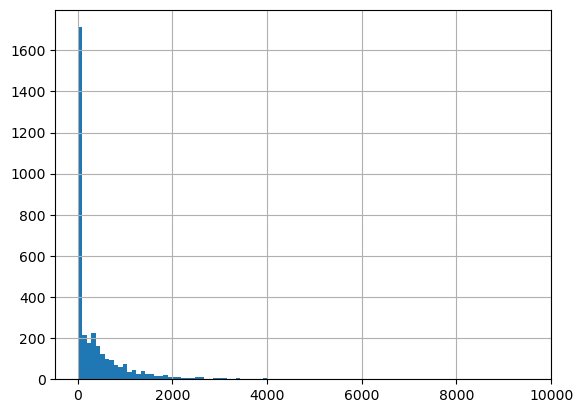

In [11]:
#confirm zero-inflated, long-tailed
outcome_df[outcome_df.TargetSales<=10_000].TargetSales.hist(bins=100)

## Feature

### Classify `Description` into `Category`

In [12]:
feature_transaction.Description.nunique()

3548

In [13]:
import numpy as np
import random
descriptions = feature_transaction.Description.unique().tolist()
print(descriptions[:5])

#randomize descriptions with seed 112 to get which categories we should use
np.random.seed(112)
random_descriptions = np.random.choice(descriptions, 1000, replace=False)
print(random_descriptions[:5])

['JUMBO BAG PINK POLKADOT', 'BLUE POLKADOT WRAP', 'RED RETROSPOT WRAP ', 'RECYCLING BAG RETROSPOT ', 'RED RETROSPOT SHOPPER BAG']
['MODERN FLORAL STATIONERY SET' 'PURPLE BERTIE GLASS BEAD BAG CHARM'
 'PARTY INVITES SPACEMAN' 'MONTANA DIAMOND CLUSTER EARRINGS'
 'SKULLS  DESIGN  COTTON TOTE BAG']


In [14]:
res = call_llama(
    'You are a product categorization assistant at a retail website.',
    'Given the following product descriptions, come up with a few product categories they should be classified into.'+'\n'.join(random_descriptions)
    )

print(res['generation'])

 <<SYS>>Based on the product descriptions, I would categorize them into the following categories:

1. Home Decor:
	* Wall art
	* Decorative items (e.g. vases, figurines, etc.)
	* Lighting (e.g. candles, lanterns, etc.)
	* Textiles (e.g. throw pillows, blankets, etc.)
2. Kitchen and Dining:
	* Cookware and utensils
	* Tableware (e.g. plates, cups, etc.)
	* Kitchen decor (e.g. wall art, etc.)
	* Food and drink items (e.g. tea, coffee, etc.)
3. Fashion and Accessories:
	* Jewelry (e.g. necklaces, earrings, etc.)
	* Handbags and wallets
	* Clothing and accessories (e.g. scarves, hats, etc.)
4. Stationery and Gifts:
	* Greeting cards
	* Gift wrap and bags
	* Stationery (e.g. notebooks, pens, etc.)
	* Gift items (e.g. candles, etc.)
5. Toys and Games:
	* Toys (e.g. stuffed animals, etc.)
	* Games and puzzles
6. Seasonal and Holiday:
	* Christmas decorations and gifts
	* Easter decorations and gifts
	* Other seasonal items (e.g. Halloween, etc.)
7. Personal Care and Wellness:
	* Beauty and pe

In [15]:
res

{'generation': ' <<SYS>>Based on the product descriptions, I would categorize them into the following categories:\n\n1. Home Decor:\n\t* Wall art\n\t* Decorative items (e.g. vases, figurines, etc.)\n\t* Lighting (e.g. candles, lanterns, etc.)\n\t* Textiles (e.g. throw pillows, blankets, etc.)\n2. Kitchen and Dining:\n\t* Cookware and utensils\n\t* Tableware (e.g. plates, cups, etc.)\n\t* Kitchen decor (e.g. wall art, etc.)\n\t* Food and drink items (e.g. tea, coffee, etc.)\n3. Fashion and Accessories:\n\t* Jewelry (e.g. necklaces, earrings, etc.)\n\t* Handbags and wallets\n\t* Clothing and accessories (e.g. scarves, hats, etc.)\n4. Stationery and Gifts:\n\t* Greeting cards\n\t* Gift wrap and bags\n\t* Stationery (e.g. notebooks, pens, etc.)\n\t* Gift items (e.g. candles, etc.)\n5. Toys and Games:\n\t* Toys (e.g. stuffed animals, etc.)\n\t* Games and puzzles\n6. Seasonal and Holiday:\n\t* Christmas decorations and gifts\n\t* Easter decorations and gifts\n\t* Other seasonal items (e.g. H

In [16]:
res = call_claude(
    'You are a product categorization assistant at a retail website.',
    'Given the following product descriptions, come up with a few product categories they should be classified into.'+'\n'.join(random_descriptions)
    )

print(res['content'][0]['text'])

Based on these product descriptions, I would suggest the following main product categories:

1. Home Decor
- Candle holders
- Picture frames
- Wall art & signs
- Clocks
- Cushions & covers
- Storage items
- Decorative objects

2. Jewelry & Accessories
- Necklaces
- Bracelets
- Earrings
- Hair accessories
- Bag charms
- Key rings

3. Garden & Outdoor
- Plant pots
- Garden tools
- Outdoor decorations
- Bird houses
- Garden markers

4. Kitchen & Dining
- Tea sets
- Mugs
- Kitchen storage
- Cutlery
- Baking accessories
- Tea towels

5. Stationery & Paper Goods
- Notebooks
- Gift wrap
- Cards
- Paper decorations
- Writing sets

6. Party & Celebrations
- Party supplies
- Gift bags
- Christmas decorations
- Easter items
- Birthday items

7. Children's Items
- Toys
- Children's tableware
- School supplies
- Kids' accessories

8. Fashion Accessories
- Bags
- Purses
- Scarves
- Travel accessories

9. Bath & Beauty
- Bathroom accessories
- Toiletry bags
- Beauty items

10. Lighting
- Lamps
- Stri

In [17]:
res

{'id': 'msg_bdrk_013qbepKfkB6ws3hWYMnjH2E',
 'type': 'message',
 'role': 'assistant',
 'model': 'claude-3-5-sonnet-20241022',
 'content': [{'type': 'text',
   'text': "Based on these product descriptions, I would suggest the following main product categories:\n\n1. Home Decor\n- Candle holders\n- Picture frames\n- Wall art & signs\n- Clocks\n- Cushions & covers\n- Storage items\n- Decorative objects\n\n2. Jewelry & Accessories\n- Necklaces\n- Bracelets\n- Earrings\n- Hair accessories\n- Bag charms\n- Key rings\n\n3. Garden & Outdoor\n- Plant pots\n- Garden tools\n- Outdoor decorations\n- Bird houses\n- Garden markers\n\n4. Kitchen & Dining\n- Tea sets\n- Mugs\n- Kitchen storage\n- Cutlery\n- Baking accessories\n- Tea towels\n\n5. Stationery & Paper Goods\n- Notebooks\n- Gift wrap\n- Cards\n- Paper decorations\n- Writing sets\n\n6. Party & Celebrations\n- Party supplies\n- Gift bags\n- Christmas decorations\n- Easter items\n- Birthday items\n\n7. Children's Items\n- Toys\n- Children's t

LLaMA 3.2 90B Output:
```
<<SYS>>Based on the product descriptions, I would categorize them into the following categories:

1. Home Decor:
	* Wall art
	* Decorative items (e.g. vases, figurines, etc.)
	* Lighting (e.g. candles, lanterns, etc.)
	* Textiles (e.g. throw pillows, blankets, etc.)
2. Kitchen and Dining:
	* Cookware and utensils
	* Tableware (e.g. plates, cups, etc.)
	* Kitchen decor (e.g. signs, magnets, etc.)
	* Food and drink items (e.g. tea, coffee, etc.)
3. Fashion and Accessories:
	* Jewelry (e.g. necklaces, earrings, etc.)
	* Handbags and wallets
	* Clothing and accessories (e.g. scarves, hats, etc.)
4. Stationery and Gifts:
	* Cards and gift wrap
	* Stationery (e.g. notebooks, pens, etc.)
	* Gift items (e.g. mugs, keychains, etc.)
5. Toys and Games:
	* Toys (e.g. stuffed animals, puzzles, etc.)
	* Games and puzzles
6. Seasonal and Holiday:
	* Christmas decorations and gifts
	* Easter decorations and gifts
	* Other seasonal items (e.g. Halloween, etc.)
7. Personal Care and Wellness:
	* Beauty and personal care items (e.g. skincare, haircare, etc.)
	* Wellness and self-care items (e.g. essential oils, etc.)
8. Outdoor and Garden:
	* Garden decor and accessories
	* Outdoor furniture and decor
	* Gardening tools and supplies

Note that some products may fit into multiple categories, but I have assigned them to the one that seems most relevant.
```

In [18]:
categories = [
    'Home Decor',
    'Kitchen and Dining',
    'Fashion Accessories',
    'Stationary and Gifts',
    'Toys and Games',
    'Seasonal and Holiday',
    'Personal Care and Wellness',
    'Outdoor and Garden',   
]

len(categories)

8

In [28]:
#loop through descriptions in batches of batch_size
res_texts = []
batch_size = 100
for i in tqdm(range(0, len(descriptions), batch_size)):
    batch = descriptions[i:i+batch_size]
    d = "\n".join(batch)
    inp = f'''Categorize the following product descriptions into {", ".join(categories)} or Others, if they do not fall into any. 
Only answer in the following format:

"product description of product #1"|"product category classified into"
"product description of product #2"|"product category classified into"
...
"product description of product #n"|"product category classified into"

Here are the product descriptions:
{d}
'''
    while True:
        res = call_claude('You are a product categorizer at a retail website', inp)
        # if res['generation_token_count'] > 1: #for llama
        if res['usage']['output_tokens'] > 1:
            break
        else:
            print('Retrying...')
            time.sleep(2)
    res_text = res['content'][0]['text'].strip().split('\n')
        #for llama
        # .replace('[SYS]','').replace('<<SYS>>','')\
        # .replace('[/SYS]','').replace('<</SYS>>','')\
    if res_text!='':
        res_texts.extend(res_text)

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
# with open('../data/sales_prediction/product_description_category.csv','w') as f:
#     f.write('"product_description"|"category"\n')
#     for i in res_texts:
#         f.write(f'{i}\n')

In [40]:
product_description_category = pd.read_csv('../data/sales_prediction/product_description_category.csv',
                                           sep='|')
product_description_category.category.value_counts(normalize=True)

category
Home Decor                    0.328636
Kitchen and Dining            0.195885
Fashion Accessories           0.138670
Stationary and Gifts          0.116122
Seasonal and Holiday          0.087373
Personal Care and Wellness    0.047351
Toys and Games                0.045096
Outdoor and Garden            0.032976
Others                        0.007892
Name: proportion, dtype: float64